In [2]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
#from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

import sklearn


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import seaborn as sns

import pydot



In [3]:
data_train = pd.read_csv('/content/trac2_hin_train.csv')
data_train.head()

ID  ... Sub-task B
0     C4.131  ...       NGEN
1     C4.638  ...       NGEN
2    C38.598  ...       NGEN
3  C4.2101.1  ...       NGEN
4   C29.14.2  ...       NGEN

[5 rows x 4 columns]

In [4]:

data_test = pd.read_csv('/content/trac2_hin_dev.csv')


In [5]:
data_train.drop(['ID','Sub-task B'], axis=1, inplace=True)
data_test.drop(['ID','Sub-task B'], axis=1, inplace=True)




In [6]:
NAG_train = data_train[(data_train['Sub-task A']=='NAG')]
OAG_train = data_train[(data_train['Sub-task A']=='CAG')]
CAG_train = data_train[(data_train['Sub-task A']=='OAG')]

In [7]:
NAG_test = data_test[(data_test['Sub-task A']=='NAG')]
OAG_test= data_test[(data_test['Sub-task A']=='CAG')]
CAG_test = data_test[(data_test['Sub-task A']=='OAG')]

In [8]:
import warnings as wrn
wrn.filterwarnings('ignore')

NAG_train["Sub-task A"] = 0 
#negatives_test["Sentiment"] = 0

OAG_train["Sub-task A"] = 1
#positives_test["Sentiment"] = 2

CAG_train["Sub-task A"] = 2
#neutrals_test["Sentiment"] = 1

#NAG_train.head()

In [9]:
import warnings as wrn
wrn.filterwarnings('ignore')

NAG_test["Sub-task A"] = 0 
#negatives_test["Sentiment"] = 0

OAG_test["Sub-task A"] = 1
#positives_test["Sentiment"] = 2

CAG_test["Sub-task A"] = 2
#neutrals_test["Sentiment"] = 1

NAG_test.head()

Text  Sub-task A
1   Bhaiya shaadi mein zaroor aana movie ka plot j...           0
2   Section 375 hai kya??? .... Ye to batate kam s...           0
4              Maine itni kam dislike kbhi nhii dekhi           0
7   जिश देश मे super30 जैसी फ़िल्म फ्लॉप ओर कबीर सि...           0
11            Bhai movie review 5 se 7 mins Bano yaar           0

In [10]:
data_train = pd.concat([NAG_train,
                 OAG_train,
                  CAG_train
                ],axis=0)

data_train.reset_index(inplace=True)

In [11]:
data_test = pd.concat([NAG_test,
                  OAG_test,
                  CAG_test
                 ],axis=0)

data_test.reset_index(inplace=True)

In [12]:

data_test = data_test.rename(columns = {'Sub-task A': 'label'}, inplace = False)

In [13]:

data_train = data_train.rename(columns = {'Sub-task A': 'label'}, inplace = False)

In [14]:
data_train

index                                               Text  label
0         0  Bollywood film dekhne ke samay logic ghar mein...      0
1         1                                   Chutiya movie...      0
2         4       Amrit Anand अब तो जुड़े ही है उनको बोलो जुड़ने      0
3         5  @Pankaj Chauhan abey tum jse aadmiyo ko ye lgt...      0
4        10                 bro house of card ka review karona      0
...     ...                                                ...    ...
3979   3957                                    Teri gand chodu      2
3980   3966                Kutti aur rand ko insult mat karna.      2
3981   3970  jo jo film dekh ke khudko kabir singh samaj ra...      2
3982   3976        Ye chutiya khud is beemari se paresaan hai.      2
3983   3978                                          Chutiye..      2

[3984 rows x 3 columns]

In [15]:
data_train.drop(['index'], axis=1, inplace=True)

In [16]:
X = data_train.Text
Y = data_train.label
#le = LabelEncoder()
#Y = le.fit_transform(Y)
#Y = Y.reshape(-1,1)


In [17]:
X_train,X_valid,y_train,y_valid = train_test_split(X,Y,test_size=0.15)

In [18]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[1, 2308, 153, 145]]


In [19]:

x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(data_test['Text'].tolist()) )


In [20]:

x_train = pad_sequences(x_train, padding='post', maxlen=150)
x_valid = pad_sequences(x_valid, padding='post', maxlen=150)
x_test = pad_sequences(x_test, padding='post', maxlen=150)

In [21]:
train_labels = np.asarray(y_train )
valid_labels = np.asarray( y_valid)

test_labels = np.asarray(data_test['label'].tolist())

In [22]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [23]:


# train autoencoder for classification with no compression in the bottleneck layer
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot


In [24]:
n_inputs = X.shape

In [25]:
t = MinMaxScaler()
t.fit(x_train)
x_train = t.transform(x_train)
x_test = t.transform(x_test)

In [26]:
sequence_length = 150

In [27]:
n_inputs = sequence_length

In [28]:

# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

In [29]:
from google.colab import drive



In [30]:
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
filepath = "/content/drive/MyDrive/Aggression_detection/autoencoderLSTM_without__aug/encoder_hin_file/encoder1.h5"



In [33]:
from keras.models import load_model


Epoch 1/30
212/212 - 2s - loss: 0.0299 - val_loss: 0.0048
Epoch 2/30
212/212 - 1s - loss: 0.0073 - val_loss: 0.0043
Epoch 3/30
212/212 - 1s - loss: 0.0068 - val_loss: 0.0039
Epoch 4/30
212/212 - 1s - loss: 0.0065 - val_loss: 0.0031
Epoch 5/30
212/212 - 1s - loss: 0.0059 - val_loss: 0.0025
Epoch 6/30
212/212 - 1s - loss: 0.0058 - val_loss: 0.0031
Epoch 7/30
212/212 - 1s - loss: 0.0052 - val_loss: 0.0022
Epoch 8/30
212/212 - 1s - loss: 0.0050 - val_loss: 0.0025
Epoch 9/30
212/212 - 1s - loss: 0.0047 - val_loss: 0.0025
Epoch 10/30
212/212 - 1s - loss: 0.0045 - val_loss: 0.0021
Epoch 11/30
212/212 - 1s - loss: 0.0044 - val_loss: 0.0026
Epoch 12/30
212/212 - 1s - loss: 0.0042 - val_loss: 0.0022
Epoch 13/30
212/212 - 1s - loss: 0.0040 - val_loss: 0.0020
Epoch 14/30
212/212 - 1s - loss: 0.0040 - val_loss: 0.0022
Epoch 15/30
212/212 - 1s - loss: 0.0038 - val_loss: 0.0026
Epoch 16/30
212/212 - 1s - loss: 0.0038 - val_loss: 0.0021
Epoch 17/30
212/212 - 1s - loss: 0.0036 - val_loss: 0.0019
Epoch 

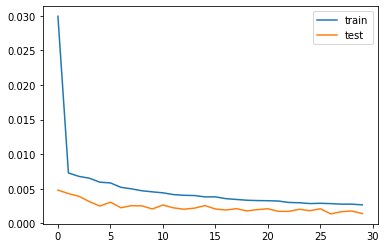

In [35]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoder_no_compress.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history = model.fit(x_train, x_train, epochs=30, batch_size=16, verbose=2, validation_data=(x_test,x_test))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)
# save the encoder to file
encoder.save(filepath)

In [36]:

# baseline in performance with logistic regression model
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# define model
model = LogisticRegression()
# fit model on training set
model.fit(x_train, y_train)
# make prediction on test set
yhat = model.predict(x_test)
# calculate accuracy
acc = accuracy_score(test_labels, yhat)
print(acc)

0.5787362086258776


In [37]:

encoder = load_model('/content/drive/MyDrive/Aggression_detection/autoencoderLSTM_without__aug/encoder_hin_file/encoder1.h5')

In [38]:

# encode the train data
X_train_encode = encoder.predict(x_train)
# encode the test data
X_test_encode = encoder.predict(x_test)

In [39]:

# define the model
model = LogisticRegression()
# fit the model on the training set
model.fit(X_train_encode, train_labels)
# make predictions on the test set
yhat = model.predict(X_test_encode)

In [40]:

acc = accuracy_score(test_labels, yhat)
print(acc)

0.5837512537612839


In [41]:
data_test['pred']= yhat

In [42]:

labels = [0,1,2]
    
print(classification_report(data_test['label'].tolist(),data_test['pred'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.60      0.96      0.74       578
           1       0.37      0.09      0.15       211
           2       0.44      0.03      0.06       208

    accuracy                           0.58       997
   macro avg       0.47      0.36      0.32       997
weighted avg       0.52      0.58      0.47       997

